In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

import tensorflow_hub as hub
#import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.0.0
Eager mode:  True
Hub version:  0.6.0
GPU is NOT AVAILABLE


In [2]:
import data
train_data, test_data = data.load_datasets_locally("/home/stavros/DATA/IMDb")
print(train_data.columns)

Index(['sentence', 'sentiment', 'polarity'], dtype='object')


## Notes

Main problem with CNNs is overfitting. Almost 100% train accuracy but always <80% validation and test accuracy.

Observations
* Dropout (even with rate=0.5) did not help.
* L2 regularization did not help, at least with the used parameters.
* Using the `Subword` tokenizer from `tensorflow_datasets` did not help: it had the same overfitting (actually slightly worse) with the default `keras` tokenizer.

## Explore how keras `Tokenizer` works

In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(list(train_data.sentence) + list(test_data.sentence))

In [153]:
x_train = tokenizer.texts_to_sequences(train_data.sentence)
x_test = tokenizer.texts_to_sequences(test_data.sentence)

In [6]:
tokens_count = np.zeros(10000 + 1)
for sentence in x_train:
    for token in sentence:
        tokens_count[token] += 1

In [155]:
train_lengths = [len(sentence) for sentence in x_train]
total_words = sum(train_lengths)
print(total_words)

test_lengths = [len(sentence) for sentence in x_test]

5942841


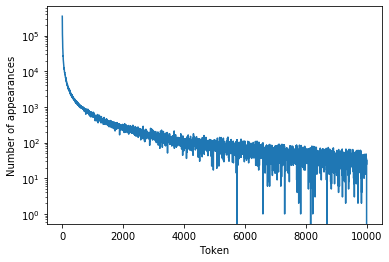

In [16]:
plt.semilogy(tokens_count[1:])
plt.xlabel("Token")
plt.ylabel("Number of appearances")
plt.show()

Most commonly appearing tokens

In [14]:
for token in range(1, 10):
    print("{}: {}".format(tokenizer.index_word[token], tokens_count[token] * 100.0 / total_words))

<UNK>: 5.882523190507705
the: 5.6563519030712754
and: 2.7612550966785077
a: 2.7434689906729797
of: 2.454162916355999
to: 2.283554279846962
is: 1.8057525012027076
br: 1.7141801370758531
in: 1.580624485830935


Distribution of sequence lengths

Mean train length: 237.71364
Train length STD: 176.49367364852034
Mean test length: 232.35268
Test length STD: 171.5344785657321


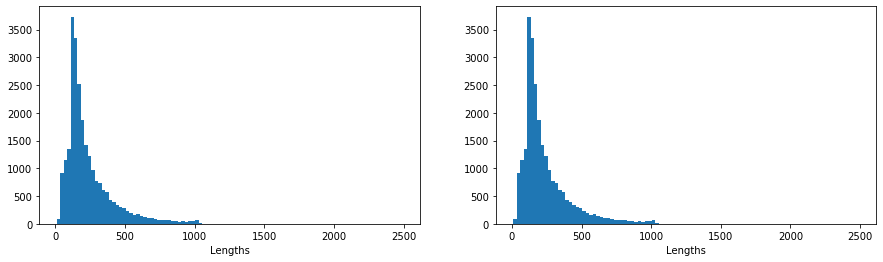

In [157]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.hist(lengths, bins=100)
print("Mean train length: {}".format(np.mean(train_lengths)))
print("Train length STD: {}".format(np.std(train_lengths)))
plt.xlabel("Lengths")

plt.subplot(122)
plt.hist(lengths, bins=100)
print("Mean test length: {}".format(np.mean(test_lengths)))
print("Test length STD: {}".format(np.std(test_lengths)))
plt.xlabel("Lengths")

plt.show()

In [28]:
tokenizer.num_words

10000

In [36]:
len(set(token for sentence in x_train for token in sentence))

9996

In [31]:
len(tokenizer.index_word)

124253

## Explore `SubwordTextEncoder` tokenizer

In [4]:
import tensorflow_datasets as tfds

In [5]:
def corpus_generator():
    for sentence in train_data.sentence:
        yield sentence
    for sentence in test_data.sentence:
        yield sentence

In [7]:
encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(corpus_generator(), target_vocab_size=20000)

In [9]:
encoder.save_to_file("imdb_train_and_test_vocab20000")

In [16]:
train_data["tokenized_sentence"] = [encoder.encode(s) for s in train_data.sentence]
test_data["tokenized_sentence"] = [encoder.encode(s) for s in test_data.sentence]

In [20]:
print(min(np.array(x).min() for x in train_data["tokenized_sentence"]))
print(max(np.array(x).max() for x in train_data["tokenized_sentence"]))
print()
print(min(np.array(x).min() for x in test_data["tokenized_sentence"]))
print(max(np.array(x).max() for x in test_data["tokenized_sentence"]))

1
20168

1
20168


## Tokenize data for CNN

Use keras tokenizer

In [71]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000, oov_token="<UNK>")
tokenizer.fit_on_texts(list(train_data.sentence) + list(test_data.sentence))
num_works = tokenizer.num_words + 1

train_data["tokenized_sentence"] = [tokenizer.texts_to_sequences([s])[0] for s in train_data.sentence]
test_data["tokenized_sentence"] = [tokenizer.texts_to_sequences([s])[0] for s in test_data.sentence]

Use `SubwordTextEncoder` from `tensorflow_datasets`

In [ ]:
encoder = ... # Load encoder
num_words = encoder.vocab_size

In [ ]:
train_data["tokenized_sentence"] = [encoder.encode(s) for s in train_data.sentence]
test_data["tokenized_sentence"] = [encoder.encode(s) for s in test_data.sentence]

## CNN sentiment classifier

In order to use `preprocess`, `data` must have a new column (`tokenized_sentence`) with the numericalized version of the sentence. Use one of the above tokenizers to create it

In [72]:
def preprocess(data: pd.DataFrame, sentence_length: int, n_classes: int = 2, dtype=tf.float32):    
    x_train = np.zeros((len(data), sentence_length))
    for i, sentence in enumerate(data.tokenized_sentence):
        n = min(sentence_length, len(sentence))
        x_train[i, :n] = np.array(sentence)[:sentence_length]
    
    y_train = data.polarity
    if n_classes > 1:
        y_train = tf.one_hot(y_train, depth=n_classes)
    
    x_train = tf.cast(x_train, dtype=dtype)
    y_train = tf.cast(y_train, dtype=dtype)
    return x_train, y_train

In [73]:
sentence_length = 128

x_train, y_train = preprocess(train_data, sentence_length, n_classes=2)
x_val, y_val = preprocess(test_data[:2000], sentence_length, n_classes=2)
x_test, y_test = preprocess(test_data, sentence_length, n_classes=2)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(25000, 128) (25000, 2)
(2000, 128) (2000, 2)
(25000, 128) (25000, 2)


In [74]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

embedding_dim = 4
dropout_rate = 0.5
l2_reg = 1e-4

model = tf.keras.models.Sequential()
model.add(layers.Input((sentence_length,)))
model.add(layers.Embedding(num_words, embedding_dim))
model.add(layers.Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                        kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.MaxPool1D())
#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu",
                       kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.MaxPool1D())
#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu",
                        kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(2, activation="softmax", kernel_regularizer=regularizers.l2(l2_reg)))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 4)            80740     
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 128, 16)           272       
_________________________________________________________________
dropout_18 (Dropout)         (None, 128, 16)           0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 64, 16)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 64, 32)            1568      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64, 32)            0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 32, 32)           

In [75]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(x=x_train, y=y_train, epochs=15, batch_size=128, validation_data=(x_val, y_val))

Train on 25000 samples, validate on 2000 samples
Epoch 1/15
25000/25000 [==============================] - 6s 235us/sample - loss: 0.5767 - accuracy: 0.6608 - val_loss: 0.4823 - val_accuracy: 0.7765
Epoch 2/15
25000/25000 [==============================] - 4s 177us/sample - loss: 0.3081 - accuracy: 0.8738 - val_loss: 0.4361 - val_accuracy: 0.8060
Epoch 3/15
25000/25000 [==============================] - 4s 175us/sample - loss: 0.2258 - accuracy: 0.9143 - val_loss: 0.4170 - val_accuracy: 0.8110
Epoch 4/15
25000/25000 [==============================] - 4s 173us/sample - loss: 0.1755 - accuracy: 0.9375 - val_loss: 0.4417 - val_accuracy: 0.8055
Epoch 5/15
25000/25000 [==============================] - 4s 177us/sample - loss: 0.1413 - accuracy: 0.9506 - val_loss: 0.4858 - val_accuracy: 0.8030
Epoch 6/15
25000/25000 [==============================] - 4s 170us/sample - loss: 0.1116 - accuracy: 0.9617 - val_loss: 0.5456 - val_accuracy: 0.7905
Epoch 7/15
25000/25000 [===========================

In [76]:
test_pred = model.predict(x_test)
print("Test accuracy: {}".format((test_pred.argmax(axis=1) == test_data.polarity).mean()))

Test accuracy: 0.77476


## Batches of varying length (do not truncate)

In [84]:
def get_generator(data: pd.DataFrame, n_classes: int = 2):
    for ids, label in zip(data.tokenized_sentence, data.polarity):
        if n_classes > 1:
            yield ids, tf.one_hot(label, depth=n_classes)
        else:
            yield np.array(ids), label

output_types = (tf.int64, tf.float32)
train_set = tf.data.Dataset.from_generator(lambda: get_generator(train_data, n_classes=2), output_types=output_types)
test_set = tf.data.Dataset.from_generator(lambda: get_generator(test_data, n_classes=2), output_types=output_types)

In [90]:
padded_shapes = ((None,),(2,))
train_batches = train_set.shuffle(25000).padded_batch(100, padded_shapes = padded_shapes)
val_batches = test_set.take(2000).padded_batch(100, padded_shapes = padded_shapes)

In [86]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

embedding_dim = 4
dropout_rate = 0.5
l2_reg = 1e-4

model = tf.keras.models.Sequential()
model.add(layers.Embedding(num_words, embedding_dim))
model.add(layers.Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                        kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.MaxPool1D())
#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu",
                       kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.MaxPool1D())
#model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu",
                        kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.Dropout(rate=dropout_rate))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(2, activation="softmax", kernel_regularizer=regularizers.l2(l2_reg)))

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 4)           80740     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, None, 16)          272       
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, None, 32)          1568      
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, None, 32)         

In [91]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_batches, epochs=5, validation_data=val_batches)

Epoch 1/5
250/250 [==============================] - 37s 148ms/step - loss: 0.1103 - accuracy: 0.9662 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
250/250 [==============================] - 39s 156ms/step - loss: 0.0885 - accuracy: 0.9745 - val_loss: 0.4146 - val_accuracy: 0.8485
Epoch 3/5
250/250 [==============================] - 39s 155ms/step - loss: 0.0733 - accuracy: 0.9806 - val_loss: 0.4397 - val_accuracy: 0.8510
Epoch 4/5
250/250 [==============================] - 37s 150ms/step - loss: 0.0609 - accuracy: 0.9834 - val_loss: 0.4590 - val_accuracy: 0.8490
Epoch 5/5
250/250 [==============================] - 36s 145ms/step - loss: 0.0559 - accuracy: 0.9862 - val_loss: 0.5569 - val_accuracy: 0.8365


In [92]:
test_pred = model.predict(x_test)
print("Test accuracy: {}".format((test_pred.argmax(axis=1) == test_data.polarity).mean()))

Test accuracy: 0.79924


In [93]:
test_pred = model.predict(x_test[:2000])
print("Test accuracy: {}".format((test_pred.argmax(axis=1) == test_data.polarity[:2000]).mean()))

Test accuracy: 0.7885
